In [1]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import torch

/home/m123/anaconda3/envs/cogvlm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
import cv2
import mat73
import numpy as np
import cv2
import os
import scipy.io
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.widgets import RectangleSelector
import math

In [3]:
np.random.seed(42)

folder_dir = 'data_np/'

mat_files = sorted([file for file in os.listdir(folder_dir) if file.endswith('.npy')])
idx = 46

print(mat_files[idx])

Flash_transm_50Hz_5J_Tamb_2.npy


In [4]:
image_sequence = np.load(folder_dir + mat_files[idx])
image_sequence = image_sequence[135:, :, :]
roi_coords = []

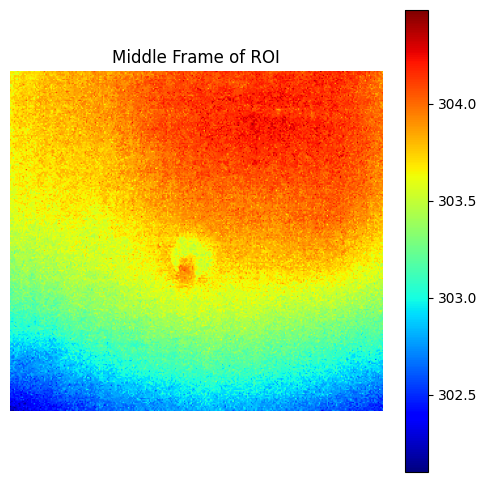

In [5]:
y1, y2, x1, x2 = 27, 287, 215, 500
image_sequence = image_sequence[y1:y2, x1:x2, :]

# image_sequence = image_sequence[5:, 120:540, :]

h, w, t = image_sequence.shape
middle_frame = image_sequence[:, :, t // 2]
plt.figure(figsize=(6, 6))
plt.imshow(middle_frame, cmap='jet')
plt.title('Middle Frame of ROI')
plt.axis('off')
plt.colorbar()
plt.show()

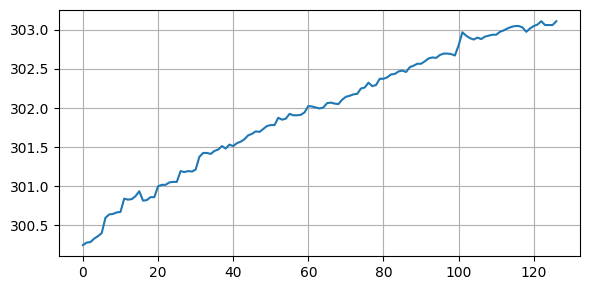

949


In [6]:
h, w, sequence_size = image_sequence.shape
plt.figure(figsize=(6, 3))
plt.plot(image_sequence.reshape(h * w, sequence_size)[5000,173:300])
plt.grid(True)
plt.tight_layout()
plt.show()

diff = np.diff(image_sequence.reshape(h * w, sequence_size)[5000,:1000])
t_pulse = np.argmax(diff)
print(t_pulse)
t_pulse = 50

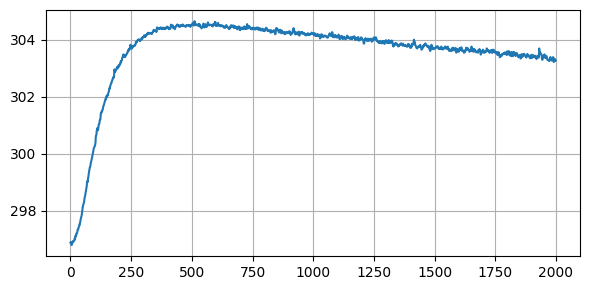

In [7]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

h, w, sequence_size = image_sequence.shape
imageMatrix = image_sequence.reshape(h * w, sequence_size)
imageMatrix = imageMatrix[:, t_pulse:]

original_len = imageMatrix.shape[1]
target_len = 2000

x_old = np.linspace(0, 1, original_len)
x_new = np.linspace(0, 1, target_len)

f = interp1d(x_old, imageMatrix, kind="linear", axis=1)
imageMatrix = f(x_new)

plt.figure(figsize=(6, 3))
plt.plot(imageMatrix[5000, :])
plt.grid(True)
plt.tight_layout()
plt.show()

imageMatrix = (imageMatrix - np.mean(imageMatrix, axis=1, keepdims=True))

n_components = 10
latent_dim = n_components

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(imageMatrix)

In [9]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1600):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x

class cnn_1d_attention(nn.Module):
    def __init__(self, latent_dim, latent_size):
        super(cnn_1d_attention, self).__init__()

        # Encoding
        self.enc_conv1 = nn.Conv1d(1, 16, kernel_size=3, stride=1, padding='same')
        self.enc_conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding='same')
        self.enc_conv3 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding='same')
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)

        # Bottleneck
        self.bottleneck = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding='same')
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=128, nhead=8, dim_feedforward=512, batch_first=True),
                num_layers=2
            )

        # Decoding
        self.upsample1 = nn.ConvTranspose1d(128, 64, kernel_size=2, stride=2)
        self.dec_conv1 = nn.Conv1d(64, 64, kernel_size=3, stride=1, padding='same')

        self.upsample2 = nn.ConvTranspose1d(64, 32, kernel_size=2, stride=2)
        self.dec_conv2 = nn.Conv1d(32, 32, kernel_size=3, stride=1, padding='same')

        self.upsample3 = nn.ConvTranspose1d(32, 16, kernel_size=2, stride=2)
        self.dec_conv3 = nn.Conv1d(16, 16, kernel_size=3, stride=1, padding='same')

        self.final_conv = nn.Conv1d(16, 1, kernel_size=1)

        # Positional Encoding
        self.positional_encoding_enc = PositionalEncoding(128)

        # MLP
        self.latent_len = latent_size

        self.mlp_enc = nn.Sequential(
            nn.Linear(128 * self.latent_len, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )

        self.mlp_dec = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 128 * self.latent_len)
        )


    def forward(self, x):
        # Encoder
        enc1 = F.relu(self.enc_conv1(x))
        enc2 = F.relu(self.enc_conv2(self.pool(enc1)))
        enc3 = F.relu(self.enc_conv3(self.pool(enc2)))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc3))

        bottleneck_transformer = bottleneck.permute(0, 2, 1)
        bottleneck_transformer = self.positional_encoding_enc(bottleneck_transformer)

        transformer_output = self.transformer_encoder(bottleneck_transformer)

        z_flat = transformer_output.reshape(transformer_output.size(0), -1)
        z = self.mlp_enc(z_flat)

        transformer_recon = self.mlp_dec(z)

        z_recon = transformer_recon.view(transformer_output.size(0), transformer_output.size(1), 128)

        # Decoder
        dec1 = self.upsample1(z_recon.permute(0, 2, 1))
        dec1 = F.relu(self.dec_conv1(dec1))

        dec2 = self.upsample2(dec1)
        dec2 = F.relu(self.dec_conv2(dec2))

        dec3 = self.upsample3(dec2)
        dec3 = F.relu(self.dec_conv3(dec3))

        x_recon = self.final_conv(dec3)

        return x_recon, z, transformer_output, z_recon

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
train_data = torch.tensor(imageMatrix, dtype=torch.float32)

subset_indices = torch.randperm(train_data.shape[0])[:3000]
subset_data = train_data[subset_indices]

pca_data = pca_result[subset_indices]
z_pca_all = torch.tensor(pca_data, dtype=torch.float32, device=device)

subset_data = subset_data.unsqueeze(1).to(device)

dataset = TensorDataset(subset_data, z_pca_all)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

latent_size = imageMatrix.shape[-1] // 8
model = cnn_1d_attention(latent_dim=latent_dim, latent_size=latent_size).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

In [11]:
import torch.nn.functional as F

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for x, z_pca in dataloader:
        x = x.to(device)
        z_pca = z_pca.to(device)

        optimizer.zero_grad()
        x_recon, z_ae, z, z_recon = model(x)

        loss_recon = F.mse_loss(x_recon, x)
        loss_recon_z = F.mse_loss(z_recon, z)

        loss = loss_recon + 1.0 * loss_recon_z

        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Total Loss = {loss.item():.4f} | Recon = {loss_recon.item():.4f} | Z = {loss_recon_z.item():.4f}")

print(f"Epoch {epoch+1}: Total Loss = {loss.item():.4f} | Recon = {loss_recon.item():.4f} | Z = {loss_recon_z.item():.4f}")

Epoch 0: Total Loss = 1.8057 | Recon = 1.7612 | Z = 0.0445
Epoch 10: Total Loss = 0.0119 | Recon = 0.0098 | Z = 0.0022
Epoch 20: Total Loss = 0.0065 | Recon = 0.0051 | Z = 0.0014
Epoch 30: Total Loss = 0.0041 | Recon = 0.0035 | Z = 0.0007
Epoch 40: Total Loss = 0.0036 | Recon = 0.0032 | Z = 0.0005
Epoch 50: Total Loss = 0.0032 | Recon = 0.0028 | Z = 0.0004
Epoch 60: Total Loss = 0.0031 | Recon = 0.0028 | Z = 0.0003
Epoch 70: Total Loss = 0.0033 | Recon = 0.0029 | Z = 0.0004
Epoch 80: Total Loss = 0.0027 | Recon = 0.0024 | Z = 0.0003
Epoch 90: Total Loss = 0.0027 | Recon = 0.0024 | Z = 0.0002
Epoch 100: Total Loss = 0.0026 | Recon = 0.0024 | Z = 0.0002


In [12]:
batch_size = 64

dataset = TensorDataset(train_data)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

model.eval()
all_latents = []

with torch.no_grad():
    for batch in loader:
        x = batch[0].to(device).unsqueeze(1)
        x_recon, z_ae, z, z_recon = model(x)
        all_latents.append(z_ae.cpu())

principal_comp = torch.cat(all_latents, dim=0).numpy()

In [13]:
pca_array = principal_comp.reshape(h, w, n_components)
pca_array = pca_array.transpose(2, 0, 1)

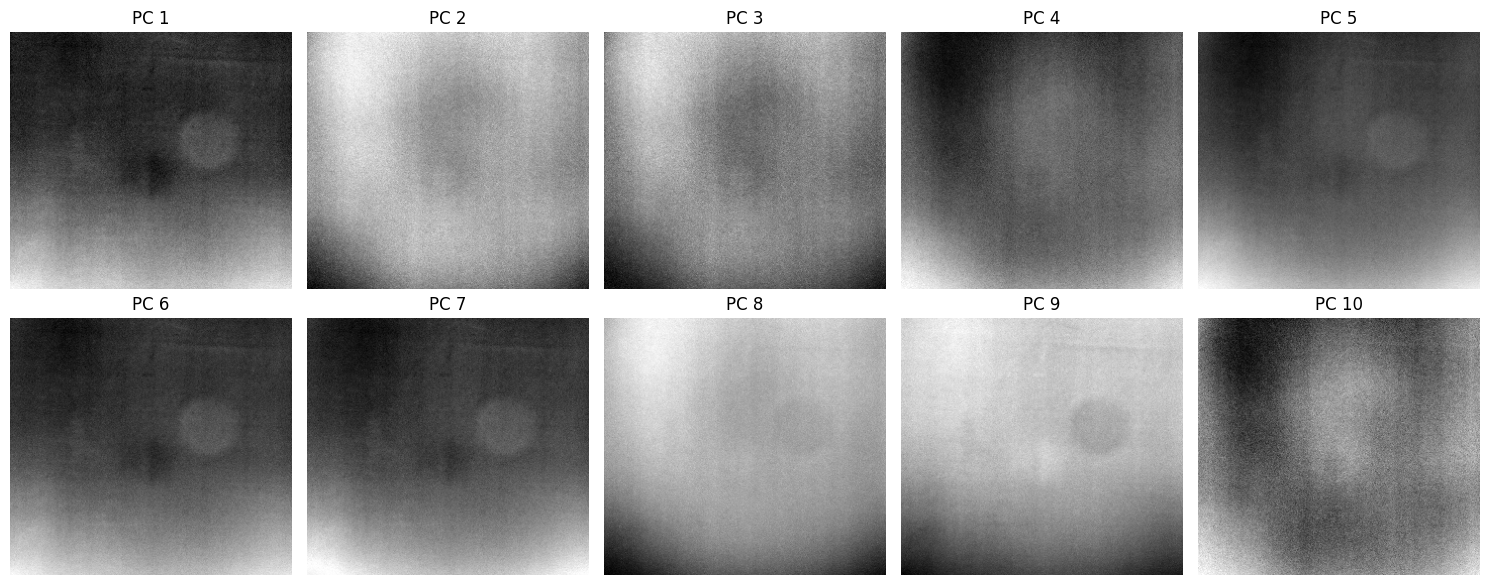

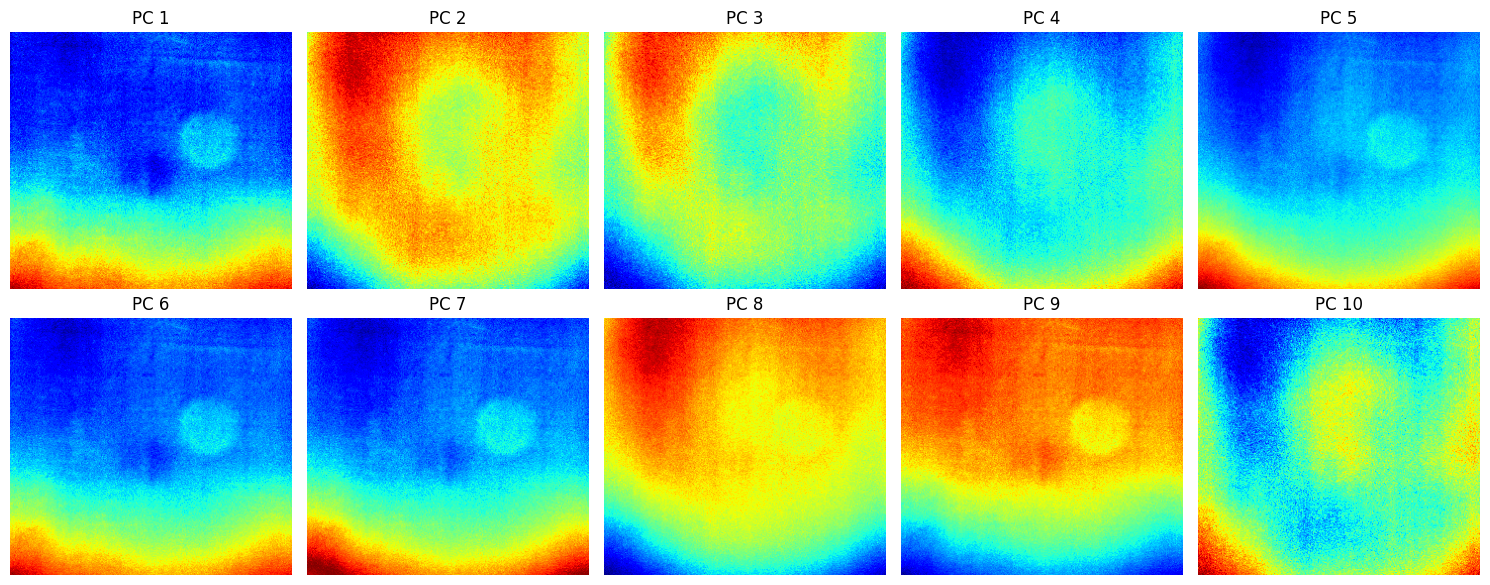

In [14]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(pca_array[i], cmap='gray') 
    ax.set_title(f'PC {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(pca_array[i], cmap='jet')
    ax.set_title(f'PC {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

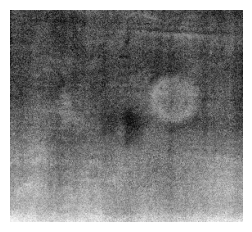

In [37]:
import torch
import cv2
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

C, H, W = pca_array.shape
flat = pca_array.reshape(C, -1).T

pca = PCA(n_components=1)
pca_result = pca.fit_transform(flat)
comp = pca_result.reshape(H, W)

comp = np.mean(pca_array, axis=0)
# comp = np.max(pca_array, axis=0)

comp -= comp.min()
comp /= comp.max()

comp = (comp * 255).astype(np.uint8)

gray_8u = cv2.normalize(comp, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
gray_8u = clahe.apply(gray_8u)

bgr = cv2.applyColorMap(gray_8u, cv2.COLORMAP_JET)
img_rgb = cv2.cvtColor(gray_8u, cv2.COLOR_GRAY2RGB)

plt.figure(figsize=(3, 3))
plt.imshow(img_rgb, cmap='gray')
plt.axis('off')
plt.show()

In [16]:
import torch
import requests
from PIL import Image
from transformers import AutoModelForCausalLM, LlamaTokenizer

tokenizer = LlamaTokenizer.from_pretrained("lmsys/vicuna-7b-v1.5", use_fast=False)
model = AutoModelForCausalLM.from_pretrained(
    "THUDM/cogvlm-grounding-generalist-hf",
    torch_dtype=torch.bfloat16,
    device_map="auto",
    trust_remote_code=True
).eval()

/home/m123/anaconda3/envs/cogvlm/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 8/8 [00:07<00:00,  1.12it/s]
/home/m123/anaconda3/envs/cogvlm/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [38]:
from PIL import Image, ImageDraw

image = Image.fromarray(img_rgb).convert("RGB")
W, H = image.size

save_path = "temp_image.jpg"
image.save(save_path)

In [39]:
expr = "defect"
# query = f"Where is {expr}? Answer in [[x0,y0,x1,y1]] format."
query = f"Where is {expr}?"
# query = f"Help me locate and determine the bounding boxes of {expr}."
# query = "Can you provide a description of the image and include the coordinates [[x0,y0,x1,y1]] for each mentioned object?"

In [40]:
image = Image.open(save_path).convert("RGB")

pack = model.build_conversation_input_ids(tokenizer, query=query, images=[image])
inputs = {
    "input_ids":      pack["input_ids"].unsqueeze(0).to("cuda"),
    "token_type_ids": pack["token_type_ids"].unsqueeze(0).to("cuda"),
    "attention_mask": pack["attention_mask"].unsqueeze(0).to("cuda"),
}

img = pack["images"][0].to("cuda", dtype=torch.bfloat16)
inputs["images"] = [img.unsqueeze(0)]      


with torch.no_grad():
    output = model.generate(**inputs, max_new_tokens=128, do_sample=False, use_cache=False, temperature=0.0)
    output_text = tokenizer.decode(output[0][inputs["input_ids"].shape[1]:])

print(output_text)

/home/m123/anaconda3/envs/cogvlm/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


[[460,450,585,645]]</s>


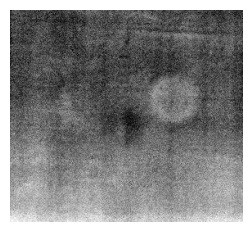

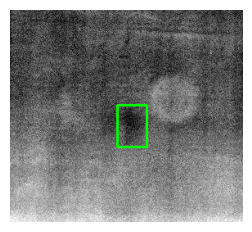

In [41]:
import json
import re
from PIL import ImageDraw, ImageFont
import matplotlib.pyplot as plt
import cv2
import numpy as np

m = re.search(r"\{.*\}", output_text, flags=re.S)
boxes_rel = []
if m:
    try:
        boxes_rel = json.loads(m.group(0)).get("boxes", [])
    except:
        boxes_rel = []
if not boxes_rel:
    arr = re.findall(r"\[\s*\[\s*\d+\s*,\s*\d+\s*,\s*\d+\s*,\s*\d+\s*\](?:\s*,\s*\[\s*\d+\s*,\s*\d+\s*,\s*\d+\s*,\s*\d+\s*\]\s*)*\s*\]", output_text)
    if arr:
        try:
            boxes_rel = json.loads(arr[0])
        except:
            boxes_rel = []

boxes_px = []
for b in boxes_rel:
    if isinstance(b, (list, tuple)) and len(b) == 4:
        x1 = int(round(b[0] / 1000.0 * W)); y1 = int(round(b[1] / 1000.0 * H))
        x2 = int(round(b[2] / 1000.0 * W)); y2 = int(round(b[3] / 1000.0 * H))
        if x2 > x1 and y2 > y1:
            boxes_px.append((x1, y1, x2, y2))

img_bgr = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
for (x1, y1, x2, y2) in boxes_px:
    cv2.rectangle(img_bgr, (x1, y1), (x2, y2), (0, 255, 0), 2)


plt.figure(figsize=(3, 3))
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

plt.figure(figsize=(3, 3))
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [42]:
data = np.load("qwen/" + mat_files[idx] + ".npz")
gt_box = data["gt_box"]

pred_box = [x1, y1, x2, y2]

In [43]:
def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    inter = max(0, xB - xA) * max(0, yB - yA)
    areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    return inter / (areaA + areaB - inter) if (areaA + areaB - inter) != 0 else 0

def center_distance(boxA, boxB):
    cxA = (boxA[0] + boxA[2]) / 2.0
    cyA = (boxA[1] + boxA[3]) / 2.0
    cxB = (boxB[0] + boxB[2]) / 2.0
    cyB = (boxB[1] + boxB[3]) / 2.0
    return np.sqrt((cxA - cxB) ** 2 + (cyA - cyB) ** 2)


def normalized_center_distance(boxA, boxB, width, height):
    d = center_distance(boxA, boxB)
    diag = np.sqrt(width**2 + height**2)
    return d / diag

iou = compute_iou(gt_box, pred_box)
dist = center_distance(gt_box, pred_box)
norm_dist = normalized_center_distance(gt_box, pred_box, width=img_rgb.shape[1], height=img_rgb.shape[0])

In [44]:
print(f"IoU: {iou}")
print(f"Center Distance: {dist}") 
print(f"Normalized Center Distance: {norm_dist}")

IoU: 0.5257270693512305
Center Distance: 12.165525060596439
Normalized Center Distance: 0.031535005573426526


In [45]:
np.savez("cogvlm/" + mat_files[idx] + ".npz",
         original=img_rgb,
         gt_box=gt_box,
         pred_box=np.array([x1, y1, x2, y2]))